In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import files

In [3]:
df_relevant = pd.read_parquet('drive/MyDrive/NLP/df_relevant.parquet', engine='pyarrow')
df_relevant.shape

(150466, 6)

In [5]:
df_relevant.columns

Index(['url', 'date', 'language', 'title', 'text', 'text_word_count'], dtype='object')

In [5]:
df_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150466 entries, 0 to 150465
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   url              150466 non-null  object
 1   date             150466 non-null  object
 2   language         150466 non-null  object
 3   title            150466 non-null  object
 4   text             150466 non-null  object
 5   text_word_count  150466 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 6.9+ MB


In [4]:
df_relevant.head()

,url,date,language,title,text,text_word_count
0,https://caledoncitizen.com/artificial-intellig...,2023-07-14,en,\r \t\t\t\t\t\t\t\t Artificial intelligence |...,Artificial intelligence Caledon Citizen Member...,1066
1,https://apolyton.net/forum/other-games/call-to...,2024-05-05,en,\r \t\t\r \t\t\tCivilization Call To Power 25t...,Civilization Call To Power 25th Anniversary Ce...,546
2,http://www.adaderana.lk/news.php?nid=109502,2025-06-15,en,\r \t\t AI workshop held at Temple Trees to en...,AI workshop held at Temple Trees to enhance pu...,577
3,https://www.thecipherbrief.com/chinas-deepseek...,2025-02-04,en,\r \t\tChina’s DeepSeek Breakthrough – and Wha...,China s DeepSeek Breakthrough and What it Mean...,870
4,https://cornellsun.com/2023/08/30/colvin-ph-d-...,2023-08-31,en,"\r \t\tColvin Ph.D. ’99, LaMoreaux ’01 to Disc...","Colvin Ph.D. 99, LaMoreaux 01 to Discuss Impac...",849


## Sentiment Analysis Using TextBlob and VADER

In [7]:
# Import sentiment analysis libraries
try:
    from textblob import TextBlob
except ImportError:
    print("Installing TextBlob...")
    import subprocess
    subprocess.run(["pip", "install", "textblob"])
    from textblob import TextBlob

try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except ImportError:
    print("Installing VADER Sentiment...")
    import subprocess
    subprocess.run(["pip", "install", "vaderSentiment"])
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


Installing VADER Sentiment...


In [8]:
def preprocess_data(df):
    """
    Preprocess the dataframe for sentiment analysis
    """
    # Create a copy to avoid modifying original
    df_processed = df.copy()

    # Convert date column to datetime
    df_processed['date'] = pd.to_datetime(df_processed['date'])

    # Remove rows with missing text
    df_processed = df_processed.dropna(subset=['text'])

    # Sort by date
    df_processed = df_processed.sort_values('date')

    return df_processed

def calculate_textblob_sentiment(text):
    """
    Calculate sentiment using TextBlob
    Returns polarity (-1 to 1) and subjectivity (0 to 1)
    """
    try:
        blob = TextBlob(str(text))
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except:
        return 0, 0

def calculate_vader_sentiment(text):
    """
    Calculate sentiment using VADER
    Returns compound score (-1 to 1)
    """
    analyzer = SentimentIntensityAnalyzer()
    try:
        scores = analyzer.polarity_scores(str(text))
        return scores['compound']
    except:
        return 0

In [10]:
def analyze_sentiment(df):
    """
    Perform sentiment analysis on the text column
    """
    print("Performing sentiment analysis...")
    print("This may take a while for large datasets...")

    # Sample data if dataset is very large (optional)
    if len(df) > 10000:
        print(f"Dataset has {len(df)} rows. Sampling 10,000 rows for faster processing...")
        df = df.sample(n=10000, random_state=42).sort_values('date')

    # Initialize VADER analyzer
    vader_analyzer = SentimentIntensityAnalyzer()

    # Calculate TextBlob sentiment
    print("Calculating TextBlob sentiment...")
    textblob_results = df['text'].apply(calculate_textblob_sentiment)
    df['textblob_polarity'] = [result[0] for result in textblob_results]
    df['textblob_subjectivity'] = [result[1] for result in textblob_results]

    # Calculate VADER sentiment
    print("Calculating VADER sentiment...")
    df['vader_compound'] = df['text'].apply(calculate_vader_sentiment)

    # Create sentiment categories
    df['textblob_category'] = pd.cut(df['textblob_polarity'],
                                   bins=[-1, -0.1, 0.1, 1],
                                   labels=['Negative', 'Neutral', 'Positive'])

    df['vader_category'] = pd.cut(df['vader_compound'],
                                bins=[-1, -0.05, 0.05, 1],
                                labels=['Negative', 'Neutral', 'Positive'])

    return df

In [11]:
# Preprocess data
df_processed = preprocess_data(df_relevant)
print(f"Preprocessed data: {len(df_processed)} articles")

Preprocessed data: 150466 articles


In [13]:
# Perform sentiment analysis
df_with_sentiment = analyze_sentiment(df_processed)

# Save sentiment analysis results to csv
df_with_sentiment.to_csv('drive/MyDrive/NLP/df_with_sentiment.csv', index=False)

# Provide a link to download the file
files.download('drive/MyDrive/NLP/df_with_sentiment.csv')

Performing sentiment analysis...
This may take a while for large datasets...
Dataset has 150466 rows. Sampling 10,000 rows for faster processing...
Calculating TextBlob sentiment...
Calculating VADER sentiment...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
def create_time_aggregations(df):
    """
    Create different time-based aggregations for visualization
    """
    # Daily aggregation
    daily_sentiment = df.groupby(df['date'].dt.date).agg({
        'textblob_polarity': ['mean', 'std', 'count'],
        'vader_compound': ['mean', 'std', 'count'],
        'textblob_subjectivity': 'mean'
    }).round(4)

    daily_sentiment.columns = ['textblob_mean', 'textblob_std', 'textblob_count',
                              'vader_mean', 'vader_std', 'vader_count', 'subjectivity_mean']
    daily_sentiment = daily_sentiment.reset_index()

    # Weekly aggregation
    weekly_sentiment = df.groupby(pd.Grouper(key='date', freq='W')).agg({
        'textblob_polarity': ['mean', 'std', 'count'],
        'vader_compound': ['mean', 'std', 'count'],
        'textblob_subjectivity': 'mean'
    }).round(4)

    weekly_sentiment.columns = ['textblob_mean', 'textblob_std', 'textblob_count',
                               'vader_mean', 'vader_std', 'vader_count', 'subjectivity_mean']
    weekly_sentiment = weekly_sentiment.reset_index()

    # Monthly aggregation
    monthly_sentiment = df.groupby(pd.Grouper(key='date', freq='ME')).agg({
        'textblob_polarity': ['mean', 'std', 'count'],
        'vader_compound': ['mean', 'std', 'count'],
        'textblob_subjectivity': 'mean'
    }).round(4)

    monthly_sentiment.columns = ['textblob_mean', 'textblob_std', 'textblob_count',
                                'vader_mean', 'vader_std', 'vader_count', 'subjectivity_mean']
    monthly_sentiment = monthly_sentiment.reset_index()

    return daily_sentiment, weekly_sentiment, monthly_sentiment

In [17]:
# Create time aggregations
daily_sentiment, weekly_sentiment, monthly_sentiment = create_time_aggregations(df_with_sentiment)

## Visualizations

In [20]:
def create_visualizations(df, daily_sentiment, weekly_sentiment, monthly_sentiment):
    """
    Create comprehensive sentiment visualizations
    """
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 24))

    # 1. Overall sentiment distribution
    plt.subplot(4, 2, 1)
    plt.hist(df['textblob_polarity'], bins=50, alpha=0.7, color='blue', label='TextBlob')
    plt.hist(df['vader_compound'], bins=50, alpha=0.7, color='red', label='VADER')
    plt.title('Distribution of Sentiment Scores', fontsize=14, fontweight='bold')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Sentiment over time (monthly)
    plt.subplot(4, 2, 2)
    plt.plot(monthly_sentiment['date'], monthly_sentiment['textblob_mean'],
             marker='o', linewidth=2, label='TextBlob', color='blue')
    plt.plot(monthly_sentiment['date'], monthly_sentiment['vader_mean'],
             marker='s', linewidth=2, label='VADER', color='red')
    plt.title('Monthly Average Sentiment Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 3. Weekly sentiment with confidence intervals
    plt.subplot(4, 2, 3)
    plt.plot(weekly_sentiment['date'], weekly_sentiment['textblob_mean'],
             color='blue', linewidth=2, label='TextBlob Mean')
    plt.fill_between(weekly_sentiment['date'],
                     weekly_sentiment['textblob_mean'] - weekly_sentiment['textblob_std'],
                     weekly_sentiment['textblob_mean'] + weekly_sentiment['textblob_std'],
                     alpha=0.3, color='blue', label='TextBlob ±1 STD')
    plt.title('Weekly Sentiment with Standard Deviation', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 4. Article volume over time
    plt.subplot(4, 2, 4)
    plt.bar(monthly_sentiment['date'], monthly_sentiment['textblob_count'],
            alpha=0.7, color='green', width=20)
    plt.title('Number of Articles Per Month', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Article Count')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 5. Sentiment categories over time (stacked bar)
    plt.subplot(4, 2, 5)
    monthly_categories = df.groupby([pd.Grouper(key='date', freq='ME'), 'textblob_category']).size().unstack(fill_value=0)
    if len(monthly_categories) > 0:
        monthly_categories.plot(kind='bar', stacked=True, ax=plt.gca(),
                               color=['red', 'gray', 'green'], alpha=0.7)
        plt.title('Monthly Sentiment Categories (TextBlob)', fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Number of Articles')
        plt.xticks(rotation=45)
        plt.legend(title='Sentiment')

    # 6. Rolling average sentiment
    plt.subplot(4, 2, 6)
    df_sorted = df.sort_values('date')
    rolling_textblob = df_sorted['textblob_polarity'].rolling(window=100, min_periods=1).mean()
    rolling_vader = df_sorted['vader_compound'].rolling(window=100, min_periods=1).mean()

    plt.plot(df_sorted['date'], rolling_textblob, label='TextBlob (100-day rolling)',
             color='blue', linewidth=2)
    plt.plot(df_sorted['date'], rolling_vader, label='VADER (100-day rolling)',
             color='red', linewidth=2)
    plt.title('Rolling Average Sentiment (100 articles)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 7. Subjectivity over time
    plt.subplot(4, 2, 7)
    plt.plot(monthly_sentiment['date'], monthly_sentiment['subjectivity_mean'],
             marker='D', color='purple', linewidth=2)
    plt.title('Subjectivity Over Time (TextBlob)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Subjectivity Score (0=Objective, 1=Subjective)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 8. Correlation between sentiment methods
    plt.subplot(4, 2, 8)
    plt.scatter(df['textblob_polarity'], df['vader_compound'], alpha=0.5, s=10)
    correlation = df['textblob_polarity'].corr(df['vader_compound'])
    plt.title(f'TextBlob vs VADER Sentiment (r={correlation:.3f})', fontsize=14, fontweight='bold')
    plt.xlabel('TextBlob Polarity')
    plt.ylabel('VADER Compound Score')
    plt.plot([-1, 1], [-1, 1], 'r--', alpha=0.8)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig



Creating visualizations...


/tmp/ipython-input-2038606258.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_categories = df.groupby([pd.Grouper(key='date', freq='ME'), 'textblob_category']).size().unstack(fill_value=0)


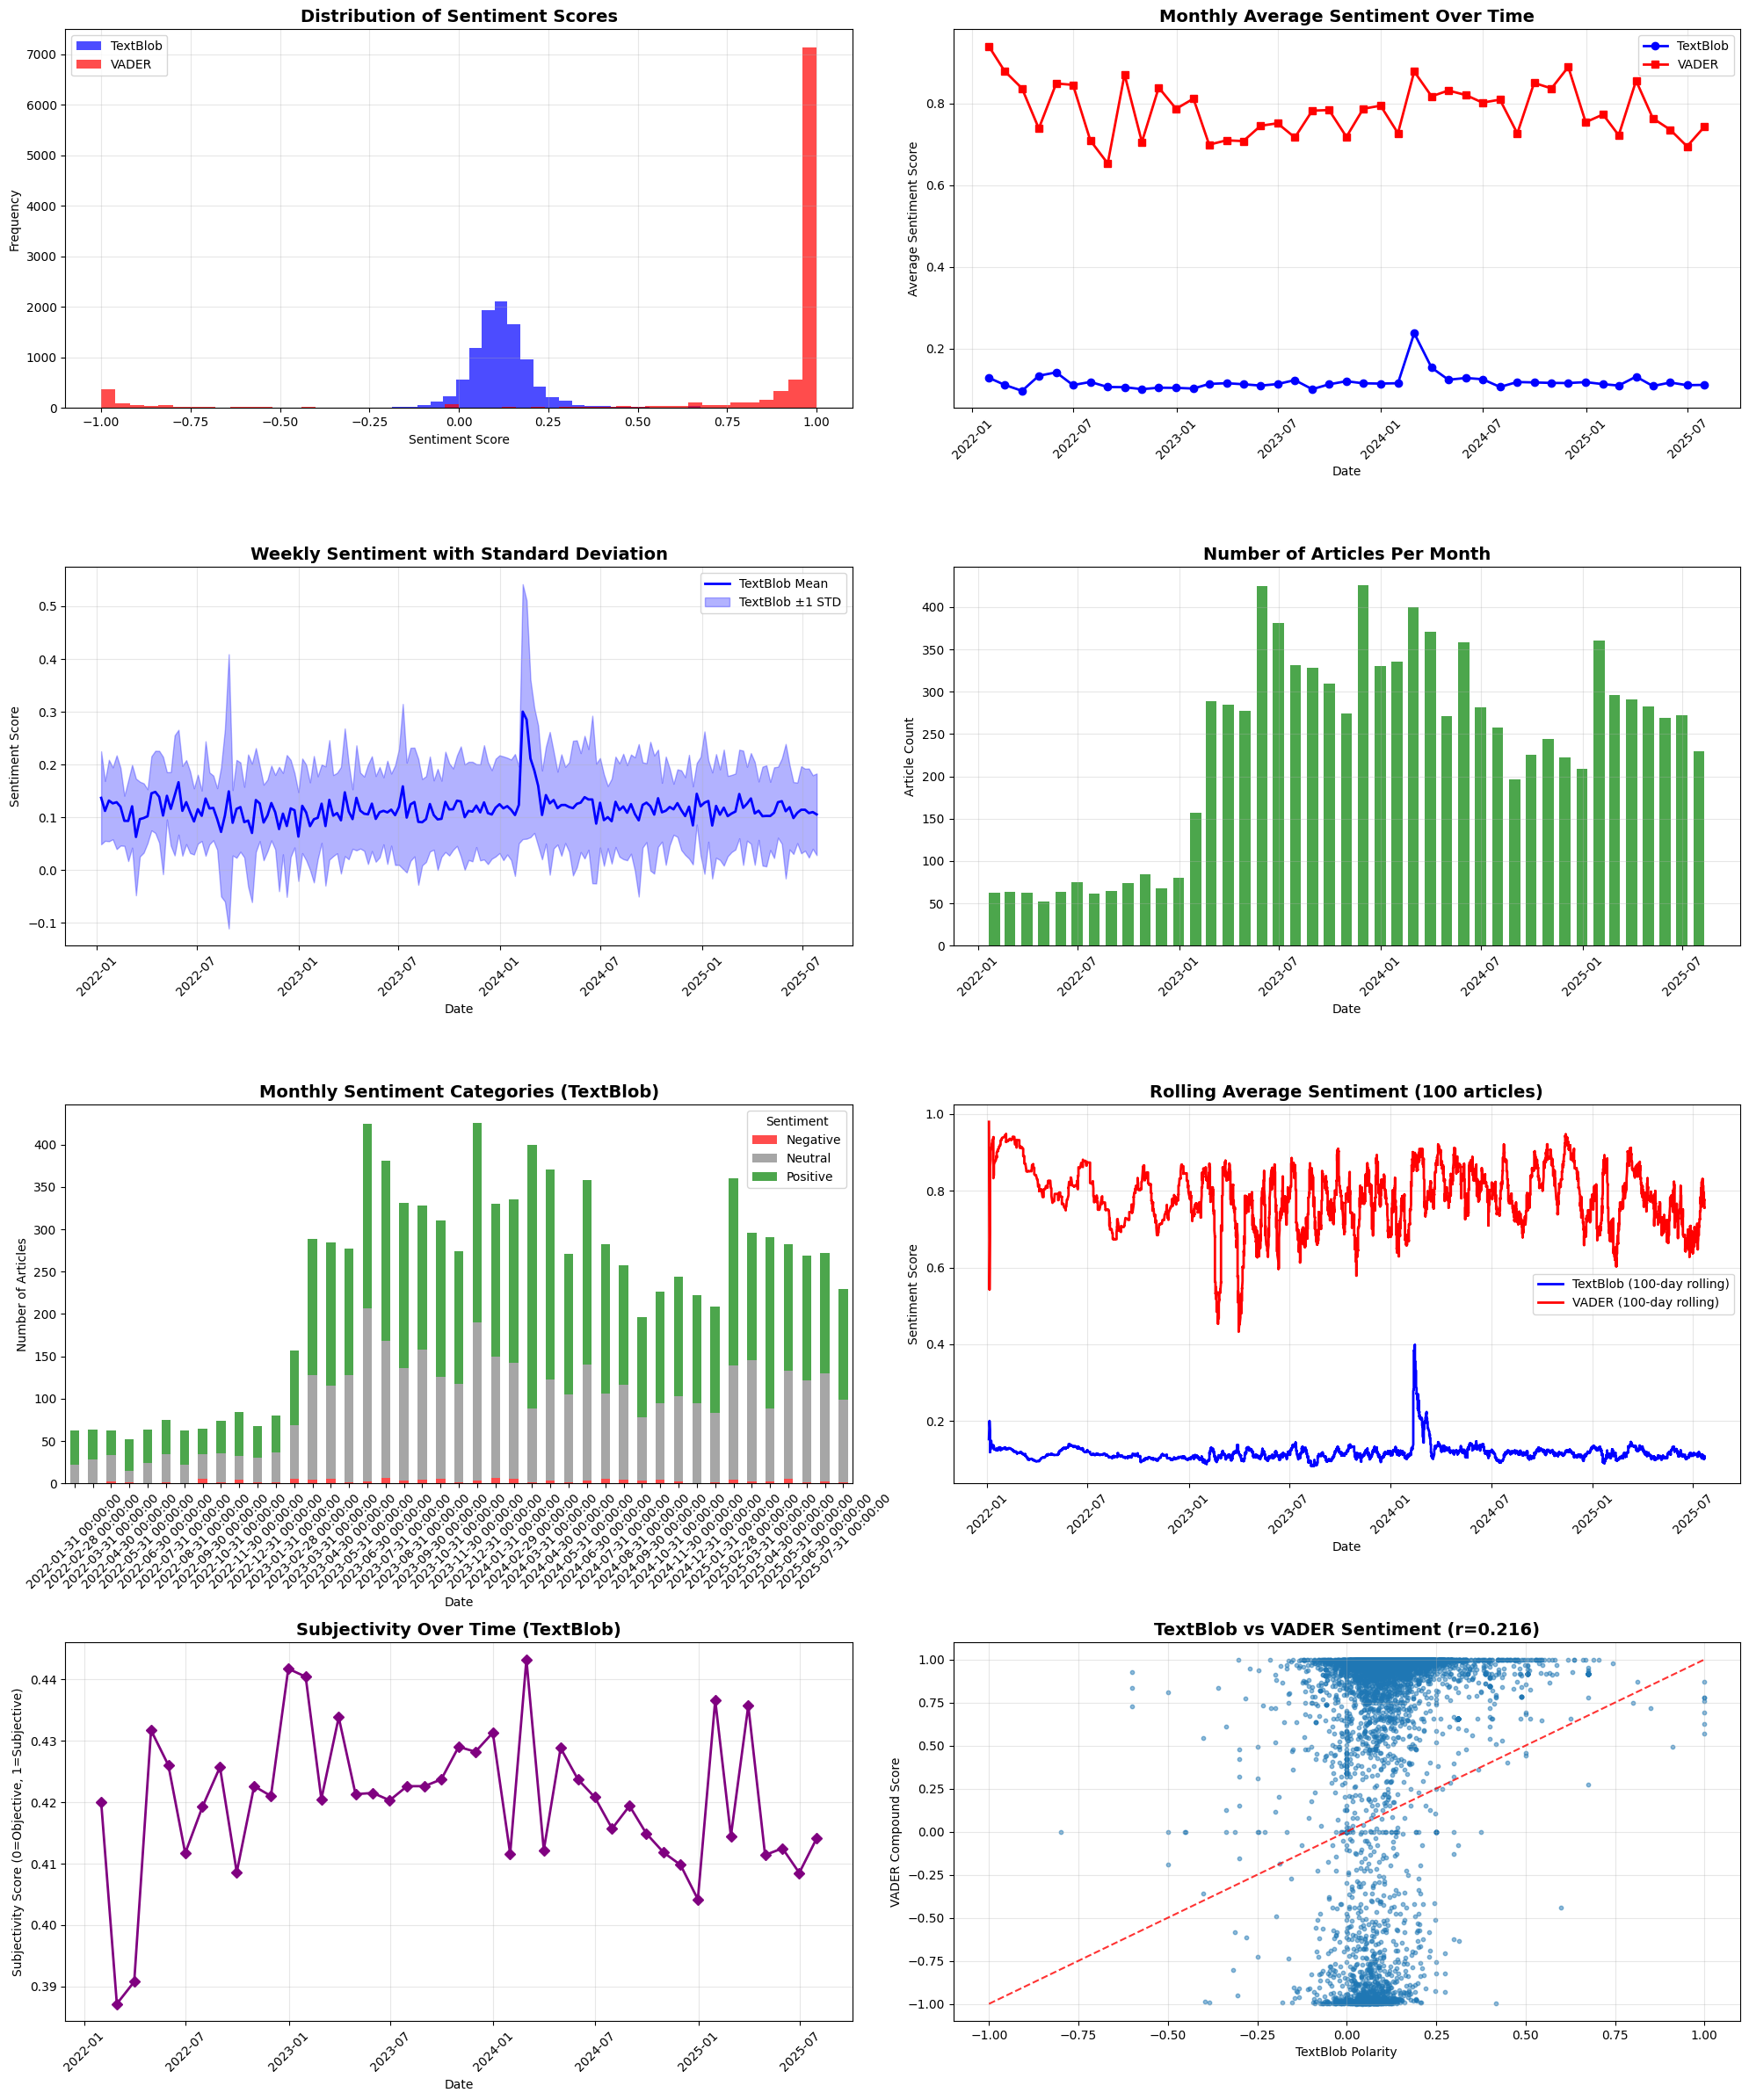

In [21]:
# Create visualizations
print("\nCreating visualizations...")
fig = create_visualizations(df_with_sentiment, daily_sentiment, weekly_sentiment, monthly_sentiment)

In [22]:
def generate_summary_statistics(df, daily_sentiment, weekly_sentiment, monthly_sentiment):
    """
    Generate summary statistics about sentiment trends
    """
    print("\n" + "="*60)
    print("SENTIMENT ANALYSIS SUMMARY")
    print("="*60)

    print(f"\nDataset Overview:")
    print(f"- Total articles analyzed: {len(df):,}")
    print(f"- Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
    print(f"- Average word count: {df['text_word_count'].mean():.0f}")

    print(f"\nSentiment Score Statistics:")
    print(f"TextBlob Polarity:")
    print(f"  - Mean: {df['textblob_polarity'].mean():.4f}")
    print(f"  - Median: {df['textblob_polarity'].median():.4f}")
    print(f"  - Std Dev: {df['textblob_polarity'].std():.4f}")

    print(f"VADER Compound:")
    print(f"  - Mean: {df['vader_compound'].mean():.4f}")
    print(f"  - Median: {df['vader_compound'].median():.4f}")
    print(f"  - Std Dev: {df['vader_compound'].std():.4f}")

    print(f"\nSentiment Distribution:")
    textblob_cats = df['textblob_category'].value_counts()
    for category, count in textblob_cats.items():
        percentage = (count / len(df)) * 100
        print(f"  - {category}: {count:,} articles ({percentage:.1f}%)")

    # Trend analysis
    if len(monthly_sentiment) > 1:
        first_month = monthly_sentiment.iloc[0]['textblob_mean']
        last_month = monthly_sentiment.iloc[-1]['textblob_mean']
        trend = "increasing" if last_month > first_month else "decreasing"
        change = abs(last_month - first_month)
        print(f"\nOverall Trend:")
        print(f"  - Sentiment is {trend} over time")
        print(f"  - Change from first to last month: {change:.4f}")

    correlation = df['textblob_polarity'].corr(df['vader_compound'])
    print(f"\nMethod Correlation:")
    print(f"  - TextBlob vs VADER correlation: {correlation:.4f}")

In [23]:
# Generate summary statistics
generate_summary_statistics(df_with_sentiment, daily_sentiment, weekly_sentiment, monthly_sentiment)


SENTIMENT ANALYSIS SUMMARY

Dataset Overview:
- Total articles analyzed: 10,000
- Date range: 2022-01-04 to 2025-07-22
- Average word count: 1309

Sentiment Score Statistics:
TextBlob Polarity:
  - Mean: 0.1207
  - Median: 0.1142
  - Std Dev: 0.1031
VADER Compound:
  - Mean: 0.7779
  - Median: 0.9924
  - Std Dev: 0.5340

Sentiment Distribution:
  - Positive: 5,829 articles (58.3%)
  - Neutral: 4,061 articles (40.6%)
  - Negative: 110 articles (1.1%)

Overall Trend:
  - Sentiment is decreasing over time
  - Change from first to last month: 0.0173

Method Correlation:
  - TextBlob vs VADER correlation: 0.2163
